# Checkpoint #2

Identify potential problems with the data:

    Evaluate the source--is it reliable or not? why? Evaluate potential biases and other problems with the data (e.g. political data gathered by a particular party trying to get a particular result. Or positive pharmaceutical data from the company selling the pharmaceutical) What will you do to deal with these problems?
   
Answer for Nutrition: The source for the nutritional value is medium reliable. It is great because we have lots of data and we didn't get band from using it. It lacks because it is not consistent in reporting the same nutrion categories for all foods, which means we have a lot of NaN values. We are going to try to refine our scraping algorithm to be more selective in its choice for ingredients. We will also attemp to scrape from a more reliable source that temporarilly blocked us because we were still learning how to webscrape.

Answer for recipes: The source of my data came from an online recipe website.  Therefore, it likely has 'reliable' recipes, but they may be biased (inasmuch that they could be 'better' or 'worse' than recipes from a physical textbook, or ones that might be accessed without payment.  The method of data collection should not influence it's contents.  However, the recipes have alot of human error. I used Regex to try to parse through the ingredients lists and measurement units as best I could, but there are still likely many hidden issues.  I don't see any reason to 'deal with' these small inconsistancies.

    Are there missing results or other things that look wrong? why? what will you do to deal with these? Values that are out of range (e.g. percentages not in 0-100,  or counts that are negative or much bigger than physically possible) must be  identified and removed or corrected.

Answer for Nutrition: One difficulty we ran into so far is the string "<1 mg" which we created a new feature that has a 1 if the value is greater than one and 0 if is <1. Now we can keep track of the items that seem like they have much information but in reality could produce an interesting result. Another difficulty is the serving size because it is very different (some unconventional) in the way they are recorded. The plan right now is to make them all the same unit and have a conversion dataframe that can make the adjustments according to the recipe instruction.

Answer for Recipes: The recipes could still be cleaned up to make the ingredients uniform across the board.  There are some 'missing' values for quantities, but these shouldn't be a problem as long as the ingredients they are associated with are things like 'pinch of salt' or 'garnish to taste'.  There are no values out of range I am aware of.  Mostly, the fine tuning work will be to make the data uniform in nature.

Evaluate the suitability of your data for answering the questions in the proposal.  If it is not suitable, adjust the questions or acquire new data as necessary.

Answer for both: The data is well suited for the suggested problem for this semester. We have categorical recipes and the nutritional values to do statiscal anylisis to identify healthier type of meals. We will create distribution graphs to discover the 'weight' of different ingredients on recipes.  We also would like to learn which category has the highest variance in ingredient use.

Revise any other aspects of your proposal in light of what you have learned from examining the data.

We keep going strong!


In [1]:
import pandas as pd
import numpy as np
from selenium import webdriver
import re
import time
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException
import pickle
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

# NUTRITIONAL CODE
# Website fetcher

In [9]:
def nutrition_website(ingredients):
    """Use Selenium to enter the given search query into the search bar of
    nutrion website and gets links to scrape data

    Returns:
        (dictonary): urls .
    """
    #initialize variables and chrome
    ingredients_dictionary = {}
    browser = webdriver.Chrome()
    browser.get("https://www.calorieking.com/us/en/")
    num_links = 3
    try:
        for i in ingredients:
            try:
                
                search_bar = browser.find_element_by_name('keywords')
                search_bar.clear()
                search_bar.send_keys(Keys.CONTROL + "a")
                search_bar.send_keys(Keys.DELETE)
                search_bar.send_keys(i)

                search_bar.send_keys(Keys.RETURN)
                
                
                words = i.split()
                x = ""
                for w in words:
                    x += ".*"+w+"+.*|"
                x = x[:-1]
#                 dash = re.compile(r"(\s)")    
#                 find = dash.sub(r"-",i)
#                 find = re.compile(".*"+find+".*",re.IGNORECASE)
                find = re.compile(x,re.IGNORECASE)
            
                

                # wait for page to load
                time.sleep(1)
                
#                 work in progress!!!!!!!!!!!!!!!
#                 hmm = browser.find_elements_by_tag_name("h2")
#                 hmm.children[0]. #go to the first child of that and get "a" tag with href
                
#                 links = browser.find_elements_by_partial_link_text(find)#[:5] # look for the word minus the first letter
                links = browser.find_elements_by_tag_name('a')
                links = [link.get_attribute("href") for link in links if isinstance(link.get_attribute("href"),str)]
                urls = [link for link in links if len(find.findall(link)) > 0]
                if len(urls) >num_links:
                    ingredients_dictionary[i] = urls[:num_links]
                elif len(urls) == 0:
                    ingredients_dictionary[i] = None
                else:
                    ingredients_dictionary[i] = urls
                

            except NoSuchElementException:
                print("could not find the search bar!")
                raise
    # close window
    finally:
        browser.close()
    # list with all the links
    return ingredients_dictionary


In [10]:
d = nutrition_website(small)

# Second: go through the sites and get the nutritional values

In [22]:
def nutrition_value(dictionary):
    """Takes in a dictionary with ingredients as keys
    look through the websites and scrape the nutritional value"""
    df_d = dict()
    browser = webdriver.Chrome()
    try:
        for k,v in zip(dictionary.keys(),dictionary.values()):
            if v is None:
                df_d[k] = {}
            else:    
                for l in v:

                    browser.get(l)
                    time.sleep(1.5)


                    #21 characters in "number of calories in"
                    try:
                        name = browser.find_elements_by_tag_name('h1')[1]
                        name = name.text[21:]
                        nut = dict()

                        c = "jss348"
                        serving = browser.find_element_by_class_name(c).text
                        s = re.compile(r"Quantity\n.?\n(.*)\nServing")
                        nut["Serving"] = s.findall(serving)[0]

                        nutrients = browser.find_elements_by_tag_name("td")
                        clean_nut = [n.text for i,n in enumerate(nutrients) if 
                                    i!= 1 and i!= 2 and len(n.text) != 0 and "%" not in n.text]
                        nut[clean_nut[0][:8]] = clean_nut[0][9:]
                        for i in range(1,len(clean_nut),2):
                            nut[clean_nut[i]] = clean_nut[i+1]

                        df_d[name] = nut
                    except IndexError as e:
                        print(l)
                        print(e)
                    except:
                        print("IDK")
                        print(l)
            
    finally:
        browser.close()
    # list with all the links
    
    
    df = pd.DataFrame.from_dict(df_d,'index')
    return df

    

In [23]:
# gets nutrional value and prints broken sites
df = nutrition_value(d)

https://www.calorieking.com/us/en/
list index out of range
https://www.calorieking.com/us/en/foods/
list index out of range
https://www.calorieking.com/recipes/
list index out of range
https://www.calorieking.com/us/en/
list index out of range
https://www.calorieking.com/us/en/foods/
list index out of range
https://www.calorieking.com/recipes/
list index out of range
IDK
https://www.calorieking.com/interactive-tools/
IDK
https://www.calorieking.com/us/en/foods/b/calories-in-average-all-brands/cuNNkJVjRDOOxMUYAdBjMA
https://www.calorieking.com/us/en/
list index out of range
https://www.calorieking.com/us/en/foods/
list index out of range
https://www.calorieking.com/recipes/
list index out of range
IDK
https://www.calorieking.com/us/en/foods/b/calories-in-average-all-brands/cuNNkJVjRDOOxMUYAdBjMA
IDK
https://www.calorieking.com/us/en/foods/b/calories-in-cool-whip-kraft/dX1ECZv1S4mS7ZgARYKDiA
IDK
https://www.calorieking.com/us/en/foods/b/calories-in-chilis-grill-bar-restaurant/evhkzJo2R-y

In [11]:
# sample_df = df
sample_df.to_csv("p_sampleD.csv")

In [24]:
# 99 ingredients
df.to_csv("p_99.csv")

## Cleaning

In [2]:
# load in data
df = pd.read_csv("p_99.csv", index_col= 0)
df.head()

,Serving,Calories,Total Fat,Saturated Fat,Polyunsaturated Fat,Monounsaturated Fat,Cholesterol,Sodium,Total Carbohydrate,Sugars,Protein,Calcium,Potassium,Iron,Vitamin A,Vitamin C,Dietary Fiber,Caffeine,Trans Fat,Alcohol
Plain Fat-Free Yogurt,cup (8.6 oz),137,0.4 g,0.3 g,< 0.1 g,0.1 g,5 mg,189 mg,18.8 g,18.8 g,14 g,488 mg,625 mg,< 1 mg,12 mg,2 mg,NaN,NaN,NaN,NaN
Plain Yogurt,cup (8.6 oz),149,8 g,5.1 g,0.2 g,2.2 g,32 mg,113 mg,11.4 g,11.4 g,8.5 g,296 mg,380 mg,< 1 mg,245 mg,1 mg,NaN,NaN,NaN,NaN
Plain Low-Fat Yogurt,cup (8.6 oz),154,3.8 g,2.5 g,0.1 g,1 g,15 mg,172 mg,17.2 g,17.2 g,12.9 g,448 mg,573 mg,< 1 mg,123 mg,2 mg,NaN,NaN,NaN,NaN
Whole-Grain Triticale Flour,tablespoon (0.3 oz),27,0.1 g,< 0.1 g,< 0.1 g,< 0.1 g,NaN,< 1 mg,5.9 g,NaN,1.1 g,3 mg,38 mg,< 1 mg,NaN,NaN,1.2 g,NaN,NaN,NaN
Bob's Red Mill Whole Wheat Flour,"serving, 1/4 cup (1.2 oz)",110,0.5 g,NaN,NaN,NaN,NaN,NaN,23 g,0.5 g,4 g,NaN,112 mg,1 mg,NaN,NaN,4 g,NaN,NaN,NaN


In [3]:
# floats for calories
df["Calories"] = df['Calories'].astype('float')

# changing the entries to floats and keeping track of units
df_less_than = {}
clean_columns = list(df.columns)[2:]

for j,c in enumerate(clean_columns):
    # take care of < 1 mg
    l_than = re.compile(r"^<.*")
    check = np.array([True if not isinstance(i,str) 
                      else False if len(l_than.findall(i))>0 
                      else True for i in df[c].values])
    df_less_than[c + " >1 mg"] = check*1
    if sum(~check) != 0:
        df[c][~check] = "0 g"
        
    # float values
    n = re.compile(r"^\d*\.?\d*")
    num = np.array([float(n.findall(i)[0]) if isinstance(i,str) else np.nan for i in df[c].values])
    
    # messurements
    m = re.compile(r"[mg]+")
    mes = np.array([m.findall(i)[0] if isinstance(i,str) else '0' for i in df[c].values])
    mask = mes == 'mg'
    if sum(mask) >0:
        num[mask] = num[mask]/1000
    df[c] = num

# append new features
df.rename(columns = {c:c+ " (g)" for c in clean_columns},inplace = True)
df_to_append = pd.DataFrame.from_dict(df_less_than)
df.head()

/home/isaac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,Serving,Calories,Total Fat (g),Saturated Fat (g),Polyunsaturated Fat (g),Monounsaturated Fat (g),Cholesterol (g),Sodium (g),Total Carbohydrate (g),Sugars (g),Protein (g),Calcium (g),Potassium (g),Iron (g),Vitamin A (g),Vitamin C (g),Dietary Fiber (g),Caffeine (g),Trans Fat (g),Alcohol (g)
Plain Fat-Free Yogurt,cup (8.6 oz),137.0,0.4,0.3,0.0,0.1,0.005,0.189,18.8,18.8,14.0,0.488,0.625,0.000,0.012,0.002,NaN,NaN,NaN,NaN
Plain Yogurt,cup (8.6 oz),149.0,8.0,5.1,0.2,2.2,0.032,0.113,11.4,11.4,8.5,0.296,0.380,0.000,0.245,0.001,NaN,NaN,NaN,NaN
Plain Low-Fat Yogurt,cup (8.6 oz),154.0,3.8,2.5,0.1,1.0,0.015,0.172,17.2,17.2,12.9,0.448,0.573,0.000,0.123,0.002,NaN,NaN,NaN,NaN
Whole-Grain Triticale Flour,tablespoon (0.3 oz),27.0,0.1,0.0,0.0,0.0,NaN,0.000,5.9,NaN,1.1,0.003,0.038,0.000,NaN,NaN,1.2,NaN,NaN,NaN
Bob's Red Mill Whole Wheat Flour,"serving, 1/4 cup (1.2 oz)",110.0,0.5,NaN,NaN,NaN,NaN,NaN,23.0,0.5,4.0,NaN,0.112,0.001,NaN,NaN,4.0,NaN,NaN,NaN


In [4]:
df_to_append.rename(index = {i:v for i,v in enumerate(df.index)},inplace = True)
new_df = pd.concat([df,df_to_append],axis= 1)
new_df.head()
# There are more than 300 ingredients here!

,Serving,Calories,Total Fat (g),Saturated Fat (g),Polyunsaturated Fat (g),Monounsaturated Fat (g),Cholesterol (g),Sodium (g),Total Carbohydrate (g),Sugars (g),...,Protein >1 mg,Calcium >1 mg,Potassium >1 mg,Iron >1 mg,Vitamin A >1 mg,Vitamin C >1 mg,Dietary Fiber >1 mg,Caffeine >1 mg,Trans Fat >1 mg,Alcohol >1 mg
Plain Fat-Free Yogurt,cup (8.6 oz),137.0,0.4,0.3,0.0,0.1,0.005,0.189,18.8,18.8,...,1,1,1,0,1,1,1,1,1,1
Plain Yogurt,cup (8.6 oz),149.0,8.0,5.1,0.2,2.2,0.032,0.113,11.4,11.4,...,1,1,1,0,1,1,1,1,1,1
Plain Low-Fat Yogurt,cup (8.6 oz),154.0,3.8,2.5,0.1,1.0,0.015,0.172,17.2,17.2,...,1,1,1,0,1,1,1,1,1,1
Whole-Grain Triticale Flour,tablespoon (0.3 oz),27.0,0.1,0.0,0.0,0.0,NaN,0.000,5.9,NaN,...,1,1,1,0,1,1,1,1,1,1
Bob's Red Mill Whole Wheat Flour,"serving, 1/4 cup (1.2 oz)",110.0,0.5,NaN,NaN,NaN,NaN,NaN,23.0,0.5,...,1,1,1,1,1,1,1,1,1,1


In [5]:
df.to_csv("p99clean.csv")

<BarContainer object of 20 artists>

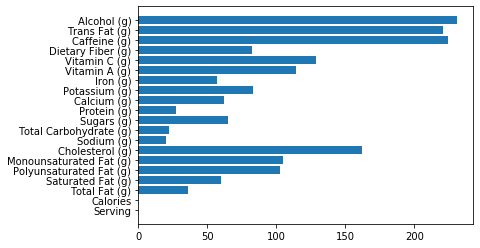

In [17]:
b = list(df.columns)
c = np.zeros(len(b))
for i in df.isna().values:
    for j,k in enumerate(i):
#         print(k*1)
        c[j] += k*1
plt.barh(b,c)
        

## Debug

In [ ]:
#### to get html and practice ######
# r = requests.get('https://www.calorieking.com/us/en/foods/f/calories-in-fresh-fruits-avocados-average-all-varieties-raw/zU9a9g9oQ5W3RHKaVFtG7A')
# with open ("fun.html",'w') as f:
#     f.write(r.text)

In [18]:
##### load in the practice html

with open("fun.html",'r') as f:
    text = f.read()

In [19]:
soup = BeautifulSoup(text,"html.parser")

In [21]:
# j = 0
for i in soup.find_all(name = "td"):
    print(i.text)
#     s = re.compile(r"Quantity.?(.*)Serving")
#     print(s.findall(i.text))

Calories 321
(1344 kJ)
% Daily Value*
Total Fat
29.5 g
45%
Saturated Fat
4.3 g
21%
Polyunsaturated Fat
3.7 g

Monounsaturated Fat
19.7 g

Sodium
14 mg
1%
Total Carbohydrate
17.1 g
6%
Dietary Fiber
13.5 g
54%
Sugars
1.3 g

Protein
4 g

Calcium
24 mg

Potassium
975 mg

Iron
1 mg

Vitamin A
291 mg

Vitamin C
20 mg



# RECIPE CODE
# Scrape the data

In [14]:
import re
import requests
import os.path
import time
import pickle
import numpy as np
from bs4 import BeautifulSoup as bs
import pandas as pd
from matplotlib import pyplot as plt
from collections import Counter
import operator

In [2]:
def get_Recipe_Base_HTML():
#     """Use the \li{requests} library to get the HTML source for the website 
#     \url{http://mc6help.tripod.com/RecipeLibrary/RecipeLibrary.htm}.
#     Save the source as a file called recipies.html.
#     If the file already exists, do not scrape the website or overwrite the file.
#     """
    if os.path.exists('recipes.html'): # checks if the folder already exists
        print("folder already here")
    else:
        with open('recipes.html', 'w') as f:
            response = requests.get("http://mc6help.tripod.com/RecipeLibrary/RecipeLibrary.htm") # gets the response from the website
            f.write(response.text)                            # writes the response from the website to the file
    return



In [3]:
get_Recipe_Base_HTML()

In [4]:
def get_HTML_extensions(filename = 'recipes.html'):
    """Return a list of the names of the text file extensions from the recipe website."""
    extensions = []
    with open(filename, 'r') as f:
        text = f.read()
    soup = bs(text,"html.parser") # create a beautiful soup object of the given code
    table_list = soup.find_all(href=True)
    for i in table_list:
        if len(i.text) > 3: # ignore the texts that are blank - all the ones
                            # we need are .txt files, so at least 3 chars long
            extensions.append(i.text)
    return extensions    # return the tag name list

In [5]:
type_list = get_HTML_extensions() # contains the extensions for all
                                  # recipes of a specific food type

In [6]:
def get_categories():
    ''' Gets all the category variables and saves them in a pickle.'''
  
    if os.path.exists('categories.pickle'): # checks if the folder already exists
        print("folder already here: returning contents")
        with open('categories.pickle','rb') as f:
            categories = pickle.load(f) # load the saved contents 
            return categories
    # otherwise, scrapes the website, pickles the information, and 
    # returns the contents
    else:
        print("folder not here yet: creating contents")
        type_list = get_HTML_extensions() # contains the extensions for all
                                          # recipes of a specific food type 
        categories = [t[:-4] for t in type_list] # remove the '.txt' from the list names
        # put a space between the words
        categories = [re.sub(r"(?<=\w)([A-Z])", r" \1", c) for c in categories]
        # then put a space between 'and' and the proceeding word (if there is an 'and')
        categories = [re.sub(r"(?<=)(and )", r" \1", c) for c in categories]
     
        with open('categories.pickle','wb') as f:
            pickle.dump(categories,f) # save the contents
            
        return categories

In [7]:
categories = get_categories()

folder not here yet: creating contents


In [8]:
def get_recipes():
    ''' Gets all the recipes and saves them in a pickle.  Doesn't scrape
    the website if the information is already there.'''

    # if the website has been scraped, doesn't scrape it again.
    # return the scraped contents
    if os.path.exists('recipes.pickle'): # checks if the folder already exists
        print("folder already here: returning contents")
        with open('recipes.pickle','rb') as f:
            recipes = pickle.load(f) # load the saved contents 
            return recipes
    # otherwise, scrapes the website, pickles the information, and 
    # returns the contents
    else:
        print("folder not here yet: creating contents")
        text_data = [] # create the list to store the contents
        for i in type_list:
            time.sleep(.25)
            # gets the text files from the links on the website
            contents = requests.get(f"http://mc6help.tripod.com/RecipeLibrary/{i}") 
            text_data.append(contents.text) # appends the contents to the list
            
        with open('recipes.pickle','wb') as f:
            pickle.dump(text_data,f) # save the contents
            
        return text_data



In [9]:
recipes = get_recipes()

folder not here yet: creating contents


In [10]:
len(recipes) # we can see how many 'categories' of recipes we have to work with

84

In [13]:
i = np.random.randint(len(recipes))
print(f"Title: {categories[i]}\n")
# print(f"List of Recipes:\n{recipes[i]}") # too long to print out here

Title: Biscotti



# Clean up the recipe data

In [15]:
def get_saved_recipes(): 
    '''Gets the saved recipes and returns them'''
    if os.path.exists('recipes.pickle'): # checks if the folder already exists
        print("folder already here: returning contents")
        with open('recipes.pickle','rb') as f:
            recipes = pickle.load(f) # load the saved contents 
            return recipes
    else:
        print("folder not here yet.  Run contents from 'Scraper.ipynb' "
              "to create the folder")

In [16]:
recipes = get_saved_recipes()

folder already here: returning contents


In [17]:
def get_saved_categories():
    ''' Gets all the category variables and returns them.'''
  
    if os.path.exists('categories.pickle'): # checks if the folder already exists
        print("folder already here: returning contents")
        with open('categories.pickle','rb') as f:
            categories = pickle.load(f) # load the saved contents 
            return categories
    # otherwise, scrapes the website, pickles the information, and 
    # returns the contents
    else:
        print("folder not here yet.  Run contents from 'Scraper.ipynb' "
              "to create the folder")

In [18]:
categories = get_saved_categories()
c_len = len(categories)

folder already here: returning contents


In [19]:
def split_category_to_recipes(category):
    '''Takes in a string of text from a single category of recipes,
       and returns a list of strings containing the recipes contained
       in that category'''
    # create the regex that all the recipes follow- not to give a 'clean'
    # cut-off, but rather to separate one recipe from the next.
    one_recipe_pattern = re.compile(r"\* Exported from MasterCook \*(.+?)Nutr\. Assoc\. : (\d+?)", re.DOTALL)
    batch = one_recipe_pattern.findall(r) # splits up the text to it's portions,
                               # but the formatting is as a list of strings
                               # in parenthesies
    singles = []
    for i in range(len(batch)):
        singles.append(batch[i][0]) # unpacks the information to make it accessable
    return singles



In [20]:
# We'll want each category to contain a list of dictionaries
# with the following information:
# name of the recipe:
split_rs = []
for r in recipes:
    split_rs.append(split_category_to_recipes(r))



In [21]:
# check and see how many total recipes we have
sum([len(split_rs[i]) for i in range(len(split_rs))])

5559

In [22]:
def get_recipe_info(recipe):
    '''Takes in a recipe string, and uses regex to parse out:
       the Title, ingredients (as a group), and the serving size
       
    '''
    title_pattern = re.compile(r"([A-Za-z]{1}[^\r\n\t\f\v]*)") # take the first match
    ingredients_batch_pattern = re.compile(r"--------------------------------(.+?)[\n\r]{4}", re.S)
    serving_size_pattern = re.compile(r"Serving Size  :\s*(\d*)")
    
    title = title_pattern.search(recipe).group(0) # we only need the first match
    serving_size = serving_size_pattern.findall(recipe)[0]
    ingredients_batch = ingredients_batch_pattern.findall(recipe)[0]
        
    return title, serving_size, ingredients_batch

In [26]:
# lets check out the names of the different recipes!
for category in split_rs[:10]:
    for recipe in category[:1]:
        name = get_recipe_info(recipe)[0]
        print(name)



Almond Liqueur
Barbecue Pecans
Banana Shake
Italian Focaccia Bread
Zippy Cheese Artichoke Oven Omelet
Ultimate Barbecue Sauce
Acorns
Swedish Rice Pudding
Shrimp and Rice Salad
Leek and Potato Soup


In [27]:
# now to create the dictionary of all this information
# to turn it into a pandas dataframe.
# Note that for now, I leave the ingredients as a list.

# to create the dictionary, it needs to be of the form
# {'col1':list(),'col2':list(),...}
category_list = []
title_list = []
serving_size_list = []
ingredients_batch_list = []
for category,category_name in zip(split_rs,categories):
    for recipe in category:
        title,serving_size,ingredients_batch = get_recipe_info(recipe)
        
        # append the appropriate elements to create the needed dictionary
        category_list.append(category_name)
        title_list.append(title)
        serving_size_list.append(serving_size)
        ingredients_batch_list.append(ingredients_batch)

In [28]:
df = pd.DataFrame({'category':category_list,
                   'title':title_list,
                   'serving size':serving_size_list,
                   'ingredients batch':ingredients_batch_list})



In [29]:
df.head()

,category,title,serving size,ingredients batch
0,Alcoholic Beverages,Almond Liqueur,1,\r\n 3 cup sugar\r\n 2 1/4 ...
1,Alcoholic Beverages,Cafe Mexicano,8,\r\n 8 cups water; cold\r\n ...
2,Alcoholic Beverages,Coffee Liqueur,1,\r\n 3 cup sugar\r\n 3 ...
3,Alcoholic Beverages,Chartreuse Cocktail,1,\r\n 1 1/2 ounces tequila; 3 T\r\n ...
4,Alcoholic Beverages,Whiskey Sour,1,\r\n 1 lemon; juiced\r\n ...


In [30]:
def get_ingredients(batch):
    l = batch.splitlines()[1:]
    measure_pattern = re.compile(r"(\d+ \d/\d|\d+/\d+|\d+)?(?=  ) +?([A-Aa-z]+)?(?=  )", re.S)
    #TODO: Add the ability to check out the meausrements
    ingredient_info_pattern = re.compile(r".{24}(.*)")
    
    ans = []
    for i in range(len(l)):
        mini = measure_pattern.findall(l[i])
        numb = [measure[0] for measure in mini if measure[0] != ''];
        if numb: numb = numb[0]; 
        else: numb = None
            
        unit = [measure[1] for measure in mini if measure[1] != '']; 
        if unit: unit = unit[0];
        else: unit = None 
            
        # get the string containing info about the ingredient
        ing_string = ingredient_info_pattern.findall(l[i])
        if ing_string: ing_string = ing_string[0];
        else: ing_string = None    
        ans.append((numb, unit, ing_string))
    return ans



In [31]:
b = df['ingredients batch']
all_ings = []
for i in range(len(b)):
    all_ings += [group[2] for group in get_ingredients(b[i])]
ingredient_counter = Counter(all_ings)
sorted_ings = sorted(ingredient_counter.items(), key=lambda kv: kv[1],reverse=True)


df_ings = pd.DataFrame(sorted_ings)
# for i in df_ings[:100]:
#     print(i)
goods = []
i = 0
while len(goods)<100:
#     print(df_ings[0][int(i)])
    if '--' not in df_ings[0][int(i)] and 'OR' not in df_ings[0][int(i)]:
        goods.append(df_ings[0][int(i)])
    i = i+1

In [39]:
goods[:8] # these contain the top 100 ingredients

['salt', 'sugar', 'water', 'butter', 'flour', 'milk', 'vanilla', 'eggs']